<a href="https://colab.research.google.com/github/rukshar69/Graph-Convolutional-Network-for-Zacharys-Karate-Club/blob/main/GCN_Karate_Club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We train a **semi-supervised GCN** model on the **Zachary's karate club network** to predict club members' community.

# Setup

In [ ]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/Personal/Projects/graphml'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).

Changed CWD to "/gdrive/My Drive/Personal/Projects/graphml"


In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None, save_path=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    # Save the plot if save_path is provided
    if save_path:
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.2)
        print(f"Plot saved successfully at {save_path}")
    else:
        plt.show()

2.1.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Introduction: Hands-on Graph Neural Networks



**Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts).

This is done by following a simple **neural message passing scheme**, where node features $\mathbf{x}_v^{(\ell)}$ of all nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating localized information from their neighbors $\mathcal{N}(v)$:

$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$

We implement Graph Neural Networks based on the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**, an extension library to the popular deep learning framework [PyTorch](https://pytorch.org/).

Let's dive into the world of GNNs by looking at a simple graph-structured example, the well-known [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). This graph describes a social network of 34 members of a karate club divided into 4 communities and documents links between members. Here, we are interested in detecting communities that arise from the member's interaction.

To solve the Karate Club community detection problem using GNN, we specifically use **Graph Convolutional Network(GCN)**

Graph Convolutional Networks (GCNs) are a type of neural network specifically designed to handle data structured as graphs. They're particularly useful for tasks involving relational data, such as social networks, citation networks, biological networks, etc. The mechanism behind GCNs involves applying convolutional operations on graph-structured data.

Here's a breakdown of the mechanism:

1. **Graph Representation:**
   - Graphs consist of nodes (representing entities) and edges (representing relationships between entities).
   - Each node typically has features associated with it (like node attributes or embeddings).

2. **Graph Convolution:**
   - GCNs perform convolutional operations on the graph data. However, unlike regular convolutions used in image data, GCNs adapt convolutional operations for graphs.

3. **Neighborhood Aggregation:**
   - GCNs operate by aggregating information from a node's neighborhood, incorporating features from neighboring nodes.
   - Convolution in GCNs involves propagating information from neighboring nodes to update the features of the central node.

4. **Learnable Parameters:**
   - GCNs learn parameters for the convolutional filters, allowing them to adapt and capture complex relationships between nodes in the graph.

Here's a simple example:

Consider a social network where nodes represent users, and edges represent friendships. Each user has attributes like age, interests, and connection strength with other users.

1. **Graph Representation:**
   - Each node (user) is represented as a feature vector containing information about the user (age, interests, etc.).
   - Edges (friendships) connect nodes in the graph.

2. **Graph Convolution:**
   - For each node, a GCN collects information from its neighboring nodes.
   - The features of a node are updated by aggregating information from its neighbors, weighted by the strength of the connections (edges).
   - The updated node features capture not only its own attributes but also information from its friends.

3. **Learnable Parameters:**
   - The GCN learns parameters (weights) for the convolutional filters, adjusting them during training to better capture relationships in the graph.

4. **Task Execution:**
   - The output of the GCN can be used for various tasks such as node classification (predicting node labels), link prediction (predicting missing edges), recommendation systems, etc.

This process continues for multiple layers in deep GCNs, allowing the model to capture increasingly complex relationships and higher-level abstractions across the graph structure.

GCNs have proven effective in various domains due to their ability to handle and learn from graph-structured data efficiently.

In Graph Convolutional Networks (GCNs), the aggregation of information from a node's neighbors weighted by the value of edges is typically done through a mathematical operation known as message passing. This process involves the application of convolutional filters on the graph data to update node representations.

Let's break it down mathematically:

1. **Graph Structure:**
   - Consider a graph $G = (V, E)$ where $V$ represents nodes and $E$ represents edges.
   - Let $A$ be the adjacency matrix representing the connections between nodes, where $A_{ij}$ is the weight of the edge between nodes $i$ and $j$.

2. **Node Representations:**
   - Each node $i$ has an initial feature representation $h_i^{(0)}$. This could be represented as a matrix $H^{(0)}$ where each row corresponds to the feature vector of a node.

3. **Message Passing:**
   - To update the node representations in a GCN, we apply a convolutional operation based on the graph structure.
   - The update rule for a single layer of GCN can be expressed as:

$$
h_i^{(l+1)} = \sigma\left(\sum_{j \in \text{neighbors}(i)} \frac{1}{{\sqrt{d_i \cdot d_j}}}\cdot h_j^{(l)} \cdot W^{(l)}\right)
$$

Here:
- $h_i^{(l)}$ is the representation of node $i$ at layer $l$.
- $\text{neighbors}(i)$ represents the neighbors of node $i$.
- $W^{(l)}$ is the weight matrix for the $l$th layer of the GCN.
- $d_i$ and $d_j$ represent the degrees of nodes $i$ and $j$ respectively.

4. **Explanation of the Equation:**
   - $h_i^{(l+1)}$ is updated by aggregating the information from its neighbors ($h_j^{(l)}$) multiplied by the learnable weight matrix $W^{(l)}$.
   - The summation involves neighbors $j$ of node $i$ with the division by $\sqrt{d_i \cdot d_j}$ as a normalization term (for scaling based on node degrees).
   - The activation function $\sigma$ introduces non-linearity (often ReLU or similar).

5. **Iteration and Stacking:**
   - This process can be repeated for multiple layers of GCN by stacking these operations sequentially to capture higher-order relationships and refine node representations.

In summary, the mathematical operation in GCNs involves updating node representations by aggregating information from neighboring nodes based on edge weights (as normalized by node degrees) and applying learnable weights through a convolutional operation, leading to refined representations capturing the graph structure.


*Multiple layers of Graph Convolutional Networks (GCNs) enable the capturing of higher-order relationships and the refinement of node representations* by allowing information to propagate across the graph in a hierarchical manner. Here's how:

1. **Local and Global Information Aggregation:**
   - Each layer of the GCN aggregates information from a node's immediate neighbors in the previous layer.
   - As the layers progress, information from further neighbors (2-hop, 3-hop, and so on) gets incorporated.
   - This allows the model to capture more extended and complex relationships beyond direct connections.

2. **Non-Linear Transformations:**
   - Each layer typically involves non-linear transformations, such as activation functions (e.g., ReLU), allowing the model to capture more complex patterns and relationships.
   - These transformations help in capturing nonlinearities in the graph structure.

3. **Hierarchical Representation Learning:**
   - Higher layers in the GCN capture more abstract and higher-level features based on the input data.
   - Lower layers might capture more local, node-specific features, while higher layers capture more global and abstract information about the entire graph.

4. **Feature Refinement:**
   - As information passes through multiple layers, the node representations undergo refinement, incorporating information from a broader neighborhood.
   - This refinement process helps nodes to acquire more comprehensive and context-rich representations, capturing nuanced relationships and features.

5. **Adaptive Learning of Weights:**
   - Each layer in the GCN has its own set of learnable parameters (weights) that are adjusted during training.
   - These weights adapt to capture the most relevant information for the task at hand, allowing the model to learn and refine representations specific to the dataset and the target task.

By stacking multiple layers, a GCN effectively leverages these mechanisms to capture increasingly intricate relationships, learn more abstract features, and refine node representations. This hierarchical learning process enables the model to understand and leverage the complex structure inherent in graph data, making it effective for various tasks involving relational data.

# Data Load and Exploration

In [ ]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


After initializing the [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) dataset, we first can inspect some of its properties.
For example, we can see that this dataset holds exactly **one graph**, and that each node in this dataset is assigned a **34-dimensional feature vector** (which uniquely describes the members of the karate club).
Furthermore, the graph holds exactly **4 classes**, which represent the community each node belongs to.

Let's now look at the underlying graph in more detail:

In [ ]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.
We can print the data object anytime via `print(data)` to receive a short summary about its attributes and their shapes:
```
Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
```
We can see that this `data` object holds 4 attributes:
- The `edge_index` property holds the information about the **graph connectivity**, *i.e.*, a tuple of source and destination node indices for each edge.
PyG further refers to
- **node features** as `x` (each of the 34 nodes is assigned a 34-dim feature vector)
- **node labels** as `y` (each node is assigned to exactly one class).
- There also exists an additional attribute called `train_mask`, which describes for which nodes we already know their community assigments.
In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

The `data` object also provides some **utility functions** to infer some basic properties of the underlying graph.
For example, we can easily infer whether there exists isolated nodes in the graph (*i.e.* there exists no edge to any node), whether the graph contains self-loops (*i.e.*, $(v, v) \in \mathcal{E}$), or whether the graph is undirected (*i.e.*, for each edge $(v, w) \in \mathcal{E}$ there also exists the edge $(w, v) \in \mathcal{E}$).

Let us now inspect the `edge_index` property in more detail:

In [ ]:
data.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

By printing `edge_index`, we can understand how PyG represents graph connectivity internally.
We can see that for each edge, `edge_index` holds a tuple of two node indices, where the first value describes the node index of the source node and the second value describes the node index of the destination node of an edge.

This representation is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.
Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero.

Importantly, PyG does not distinguish between directed and undirected graphs, and treats undirected graphs as a special case of directed graphs in which reverse edges exist for every entry in `edge_index`.

We can further visualize the graph by converting it to the `networkx` library format, which implements, in addition to graph manipulation functionalities, powerful tools for visualization:

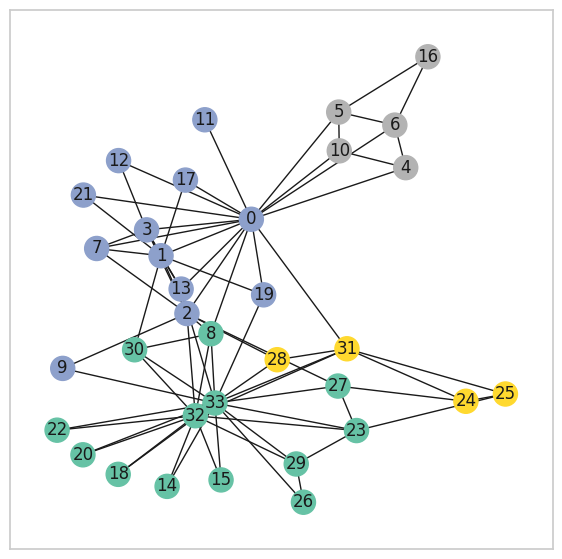

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

# Implementing Graph Neural Networks

For this, we will use on of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

With this, we are ready to create our first Graph Neural Network by defining our network architecture in a `torch.nn.Module` class:

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Here, we first initialize all of our building blocks in `__init__` and define the computation flow of our network in `forward`.
We first define and stack **three graph convolution layers**, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away).
In addition, the `GCNConv` layers reduce the node feature dimensionality to $2$, *i.e.*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Each `GCNConv` layer is enhanced by a [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh) non-linearity.

After that, we apply a single linear transformation ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) that acts as a classifier to map our nodes to 1 out of the 4 classes/communities.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN.
We proceed to initialize our final model via `GCN()`, and printing our model produces a summary of all its used sub-modules.


## Embedding the Karate Club Network

Let's take a look at the node embeddings produced by our GNN.
Here, we pass in the initial node features `x` and the graph connectivity information `edge_index` to the model, and visualize its 2-dimensional embedding.

Embedding shape: [34, 2]


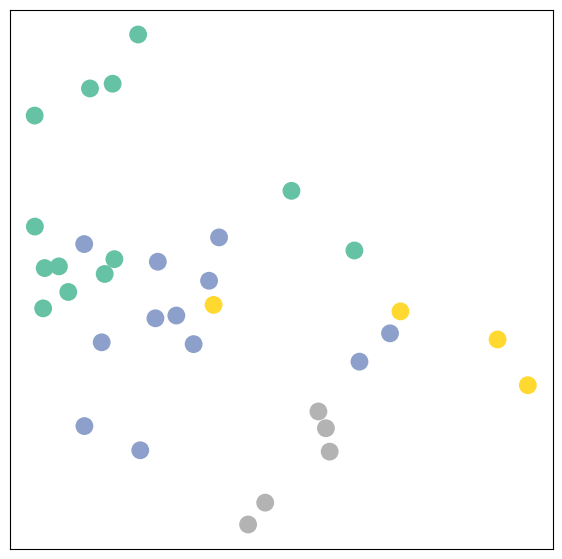

In [ ]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph.
Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized **completely at random** and we have not yet performed any training so far!
This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

## Training on the Karate Club Network

But can we do better? Let's look at an example on how to train our network parameters based on the knowledge of the community assignments of 4 nodes in the graph (one for each community):

We make use of a semi-supervised or transductive learning procedure: We simply train against one node per class, but are allowed to make use of the complete input graph data.

Training our model is very similar to any other PyTorch model.
In addition to defining our network architecture, we define a loss critertion (here, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and initialize a stochastic gradient optimizer (here, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).
After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass.

Note that our semi-supervised learning scenario is achieved by the following line:
```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.
Here, this is implemented by filtering the output of the classifier `out` and ground-truth labels `data.y` to only contain the nodes in the `train_mask`.

Let us now start training and see how our node embeddings evolve over time (best experienced by explicitely running the code):

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))
losses = [] #record the losses/epoch

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    losses.append(loss.item())
    if epoch % 1 == 0:
        save_folder = root
        file_name = f'train_node_embeddings/{epoch}.png'
        save_path = os.path.join(save_folder, file_name)
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss, save_path=save_path)
        time.sleep(0.3)

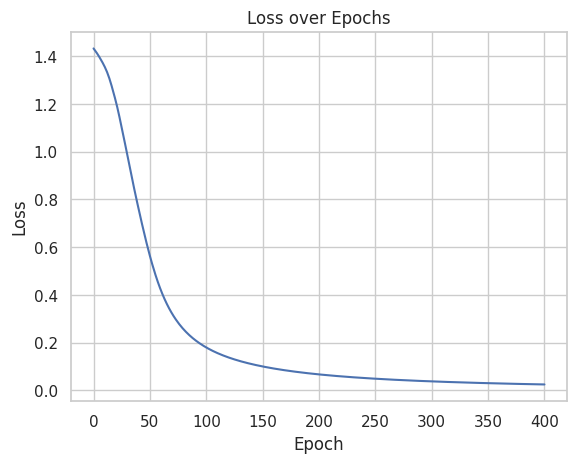

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plotting with seaborn style
sns.set(style="whitegrid")
# Create a list of losses
#losses = [1.2, 0.8, 0.9, 1.1, 1.3, 1.5, 1.4, 1.2, 1.0, 0.9]

# Create a line plot using Seaborn
sns.lineplot(x=range(len(losses)), y=losses)

# Add labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")

# Show the plot
plt.show()

### Make video of Node embeddings

In [ ]:
import cv2


# Path to the folder containing PNG images
images_folder =  os.path.join(root, 'train_node_embeddings')
print(images_folder)

# Output video file name
output_video_path = os.path.join(root, 'training_node_embeddings.mp4')

filenames = [str(i)+'.png' for i in range(401)]

# Get a list of all image files in the folder
image_files = [os.path.join(images_folder, file) for file in filenames]

# Specify video properties (you can adjust the frame rate and resolution)
frame_rate = 5  # Adjust as needed
width, height = 640, 480  # Adjust as needed

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format
out = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (width, height))

# Read each image and write it to the video
for image_path in image_files:
    img = cv2.imread(image_path)
    img = cv2.resize(img, (width, height))  # Resize if needed
    out.write(img)

# Release the VideoWriter and print a message
out.release()
print(f"Video created successfully at: {output_video_path}")


/gdrive/My Drive/Personal/Projects/graphml/train_node_embeddings
Video created successfully at: /gdrive/My Drive/Personal/Projects/graphml/training_node_embeddings.mp4


## Predict node classes

In [ ]:
predictions, _ = model(data.x, data.edge_index)  # Perform a single forward pass.

In [ ]:
# Use argmax to get the index for each row of the PyTorch tensor 'predictions'
prediction_label = predictions.argmax(dim=1)

# Save the prediction labels in an array named 'prediction_label'
prediction_labels = prediction_label.numpy()
true_labels = data.y.numpy()

In [ ]:
# Calculate accuracy
accuracy = np.mean(prediction_labels == true_labels)
print("Accuracy:", accuracy)

Accuracy: 0.8235294117647058


In [ ]:
# Calculate precision, recall, and f1-score for each class
class_wise_metrics = {}
for class_label in np.unique(true_labels):
    class_predictions = prediction_labels == class_label
    class_truth = true_labels == class_label

    tp = np.sum(class_predictions & class_truth)
    fp = np.sum(class_predictions & ~class_truth)
    fn = np.sum(~class_predictions & class_truth)

    precision = tp / (tp + fp) if tp + fp > 0 else 0

    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    class_wise_metrics[class_label] = {
        "precision": precision,
        "recall": recall,
        "f1-score": f1
    }

print("Class-wise metrics:", class_wise_metrics)


Class-wise metrics: {0: {'precision': 0.7058823529411765, 'recall': 0.9230769230769231, 'f1-score': 0.8000000000000002}, 1: {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8}, 2: {'precision': 0.75, 'recall': 0.75, 'f1-score': 0.75}, 3: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0}}


In [ ]:
import pandas as pd
# Convert dictionary to DataFrame
df = pd.DataFrame.from_dict(class_wise_metrics, orient='index')

# Display the DataFrame
print(df)

   precision    recall  f1-score
0   0.705882  0.923077      0.80
1   1.000000  0.666667      0.80
2   0.750000  0.750000      0.75
3   1.000000  1.000000      1.00


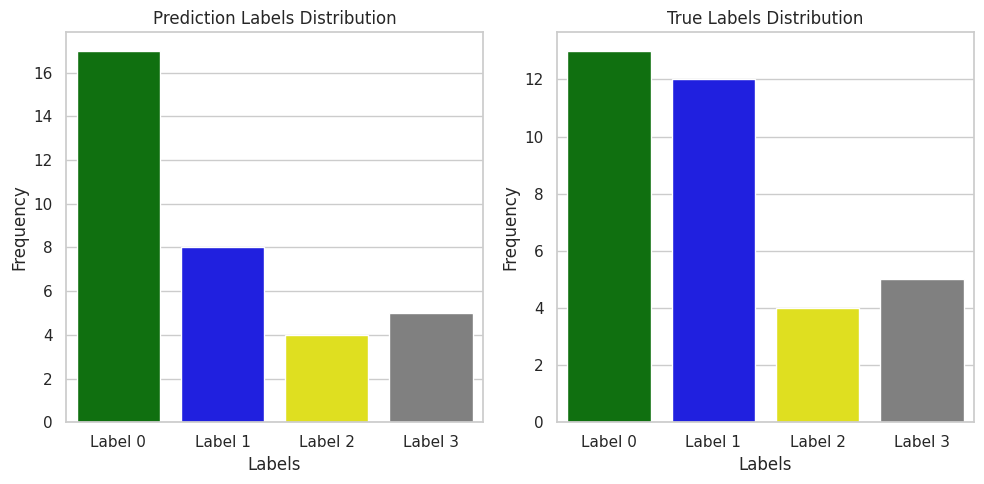

In [ ]:
# Count occurrences of each label in the arrays
prediction_counts = np.bincount(prediction_labels)
true_counts = np.bincount(true_labels)

# Labels for x-axis
labels = ['Label 0', 'Label 1', 'Label 2', 'Label 3']

# Define custom colors for each label
custom_colors = ['green', 'blue', 'yellow', 'grey']

# Creating subplots for side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotting prediction labels distribution
sns.barplot(x=np.arange(len(labels)), y=prediction_counts, palette=custom_colors,ax=axes[0])
axes[0].set_title('Prediction Labels Distribution')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Frequency')
axes[0].set_xticklabels(labels)

# Plotting true labels distribution
sns.barplot(x=np.arange(len(labels)), y=true_counts,palette=custom_colors, ax=axes[1])
axes[1].set_title('True Labels Distribution')
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Frequency')
axes[1].set_xticklabels(labels)

plt.tight_layout()
plt.show()

As one can see, our 3-layer GCN model manages to linearly separate the communities and classifying most of the nodes correctly. The loss has also gradually decreased to a near plateau meaning the training is progressing towards the right direction. The overall *accuracy* is over **82** percent. While looking at the class-based metrics(f1-score, precision, and recall), **label 1** has the least *f1-score* of *75%*. By observing the class distribution of the true and predicted labels in the bar graphs, we can see some of the label 1 points have been classified as label 0.

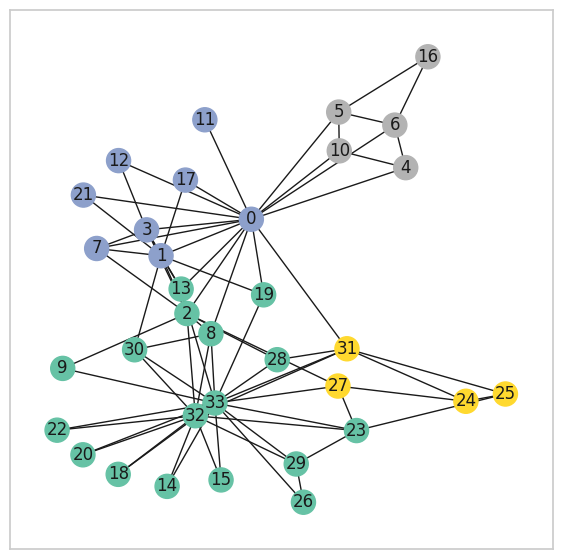

In [ ]:
visualize_graph(G, color=prediction_label)

Comparing graph visualizations of prediction labels and true labels, we find, at the fuzzy border region between label 0 and label 1 (green and blue respectively), some blue label 1 nodes are misclassified as green label 0. Hence, label 1 had less f1-score.

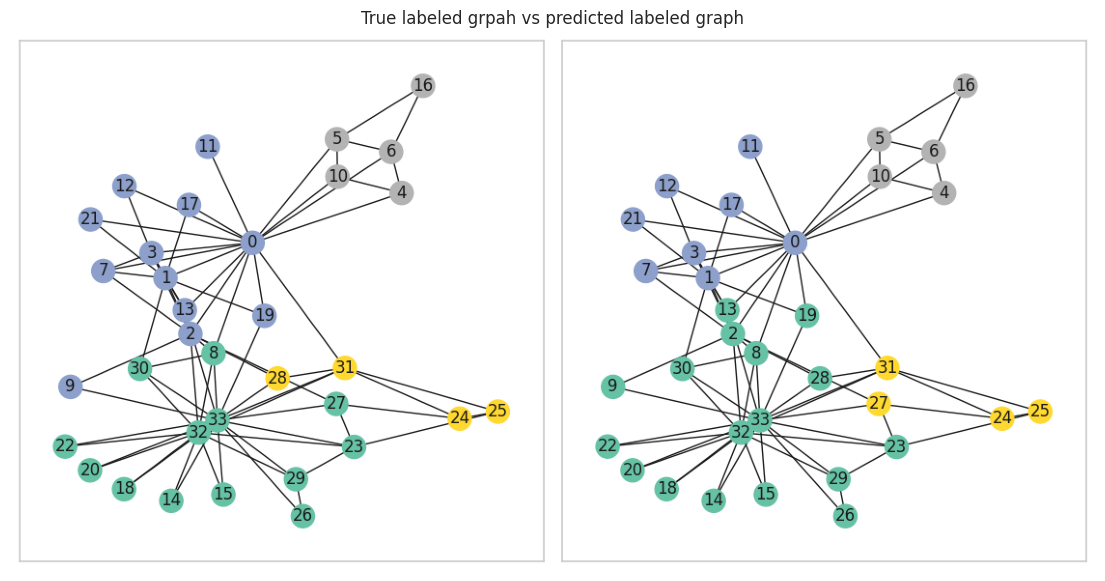

In [ ]:
from PIL import Image

# Open the images
image1 = Image.open('true_graph.png')  # Replace '1.png' with the actual path to your first image
image2 = Image.open('prediction_graph.png')  # Replace '2.png' with the actual path to your second image

# Ensure both images have the same height
min_height = min(image1.height, image2.height)
image1 = image1.resize((int(image1.width * min_height / image1.height), min_height))
image2 = image2.resize((int(image2.width * min_height / image2.height), min_height))

# Concatenate the images horizontally
concatenated_image = Image.new('RGB', (image1.width + image2.width, min_height))
concatenated_image.paste(image1, (0, 0))
concatenated_image.paste(image2, (image1.width, 0))

# Save or display the concatenated image
#concatenated_image.show()  # To display the concatenated image
#concatenated_image.save('concatenated_image.png')  # To save the concatenated image

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize = (14,10))

# Display the image
ax.imshow(concatenated_image)
ax.set_title('True labeled grpah vs predicted labeled graph')  # Set the title

# Hide the axis to display only the image
ax.axis('off')
# Save the image with title
plt.savefig('predict_true_graph_comparison.png')  # Save the image with title
plt.show()
